## 0. Imports

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import LSTM
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense
import yfinance as yf
import datetime

In [259]:
#import data
df = pd.read_csv('../../long_short_local/raw_data/cleaned_data_2y.csv')

## 1. Splitting Data in Train and Validation

In [3]:
# R
def split_train_val(df):
    length_data = len(df)    
    split_ratio = 0.7           # %70 train + %30 validation
    length_train = round(length_data * split_ratio)  
    length_validation = length_data - length_train
    #print("Data length :", length_data)
    #print("Train data length:", length_train)
    #print("Validation data lenth:", length_validation)
    
    train_data = df[:length_train].iloc[:,:2] 
    train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object

    validation_data = df[length_train:].iloc[:,:2]
    validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
    
    return train_data, validation_data, length_train, length_validation

## 2. Creating Train Dataset from Train split

In [4]:
# R
# create dataset from train split
def train_split(train_data):
    dataset_train = train_data.iloc[:, 1].values
    # Change 1d array to 2d array
    # Changing shape from (1692,) to (1692,1)
    dataset_train = np.reshape(dataset_train, (-1,1))
    #dataset_train.shape
    dataset_train_scaled = dataset_train
    
    return dataset_train_scaled

## 3. Creating X_train and y_train from Train data 

We have train data composed of ratios over days

So, it has 1184 ratios corresponding 1184 days

My aim is to predict the ratio (closing) of the next day.

I can use a time step of 2 days.

I will pick first 2 ratios (day 0 to 2), 1st 2 ratio will be in 
X_train data

Then predict the ratio of 3rd day; and 3rd ratio will be in y_train data

Again, i will pick ratios from 1 to 3, those will be in X_train data

Then predict the next days ratio, 4th ratio will be in y_train data



In [5]:
def create_x_y_train(df, length_train):
    X_train = []
    y_train = []

    time_step = 100 #change that?

    for i in range(time_step, length_train):
        X_train.append(dataset_train_scaled[i-time_step:i,0:1])
        y_train.append(dataset_train_scaled[i,0:1])

    # convert list to array
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    y_train = np.reshape(y_train, (y_train.shape[0],1))
    
    X_train = X_train[:int(X_train.shape[0]*0.95)]
    X_val = X_train[int(X_train.shape[0]*0.95):]
    y_train = y_train[:int(y_train.shape[0]*0.95)]
    y_val = y_train[int(y_train.shape[0]*0.95):]
    
    return X_train, X_val, y_train, y_val, time_step

## 4. Creating Test Dataset from Validation Data

In [6]:
# R
#Converting array and scaling
def create_x_y_test(validation_data, length_validation, time_step):
    dataset_validation = validation_data.iloc[:,1].values  # getting "Ratio" column and converting to array
    dataset_validation = np.reshape(dataset_validation, (-1,1))  # converting 1D to 2D array
    #scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling  values to between 0 and 1
    scaled_dataset_validation = dataset_validation
    
    X_test = []
    y_test = []

    for i in range(time_step, length_validation):
        X_test.append(scaled_dataset_validation[i-time_step:i,0])
        y_test.append(scaled_dataset_validation[i,0])
        
    # Converting to array
    X_test, y_test = np.array(X_test), np.array(y_test)
    X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
    y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array
    
    return X_test, y_test

## 5a. Creating LSTM model

In [7]:
def lstm_model(X_train, y_train, X_val, y_val, X_test, y_test):
    es = EarlyStopping(patience=20, restore_best_weights=True)
    model_lstm = Sequential()

    model_lstm.add(LSTM(20,return_sequences=False,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
    model_lstm.add(Dense(32))
    model_lstm.add(Dense(1))

    model_lstm.compile(loss = "mape", optimizer = "rmsprop", metrics = ["mae", "mape"])
    history2 = model_lstm.fit(X_train, y_train, epochs = 400, batch_size = 64,validation_data = (X_val, y_val),callbacks=[es])
    mape = model_lstm.evaluate(X_test, y_test)
    
    return mape[2], model_lstm

## 5b. LSTM forecast

In [232]:
# func 1
def prep_data(df):
    df.set_index('Date', inplace=True)
    tmp_list = []
    fut_list = []
    
    #Getting the last 100 days records
    for ratio in df.columns:
        fut_inp = df[len(df)-100:][ratio]
        fut_inp = fut_inp.values.reshape(1,-1)
        fut_list.append(fut_inp)
        tmp_inp = list(fut_inp)
        #Creating list of the last 100 data
        tmp_inp = tmp_inp[0].tolist()
        tmp_list.append(tmp_inp)
    
    return tmp_list, fut_list

In [195]:
#test_df[49:]['ALB_ZBRA']

49     0.326211
50     0.336910
51     0.328042
52     0.343155
53     0.349058
         ...   
492    0.813028
493    0.814154
494    0.815450
495    0.816374
496    0.822204
Name: ALB_ZBRA, Length: 448, dtype: float64

In [183]:
validation_data[49:]['PEG_O']

397    0.987904
398    1.004751
399    1.016249
400    1.008357
401    1.002095
         ...   
492    0.920803
493    0.933379
494    0.935173
495    0.950678
496    0.951858
Name: PEG_O, Length: 100, dtype: float64

In [119]:
#Getting the last 100 days records
fut_inp = validation_data[49:]['PEG_O']

In [120]:
fut_inp = fut_inp.values.reshape(1,-1)

In [121]:
tmp_inp = list(fut_inp)

In [122]:
fut_inp.shape

(1, 100)

In [123]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [256]:
# func 2
def lstm_predict(model, tmp_list, fut_list):
    # predicting next 30 days price suing the current data
    # it will predict in sliding window manner (algorithm) with stride 1
    preds_list = []
    for x in range(0, len(tmp_list)):
        tmp_inp = tmp_list[x]
        fut_inp = fut_list[x]
        lstm_preds=[]
        n_steps=100
        i=0
        while(i<30):

            if(len(tmp_inp)>100):
                fut_inp = np.array(tmp_inp[1:])
                fut_inp=fut_inp.reshape(1,-1)
                fut_inp = fut_inp.reshape((1, n_steps, 1))
                yhat = model.predict(fut_inp, verbose=0)
                tmp_inp.extend(yhat[0].tolist())
                tmp_inp = tmp_inp[1:]
                lstm_preds.extend(yhat.tolist())
                i=i+1
            else:
                fut_inp = fut_inp.reshape((1, n_steps,1))
                yhat = model.predict(fut_inp, verbose=0)
                tmp_inp.extend(yhat[0].tolist())
                lstm_preds.extend(yhat.tolist())
                i=i+1
           
        preds_list.append(lstm_preds)

    return preds_list

In [372]:
# func 3
# get LSTM predictions and build ratio df for the next 30 days
def clean_df(lstm_preds, test_df):
    check_df = test_df.copy()
    df = pd.DataFrame()
    cols = list(test_df.columns)
    cols.pop(0)
    preds_array = np.array(lstm_preds)
    preds_resh = preds_array.reshape(7,30)
    final_df = pd.DataFrame(preds_resh).T
    final_df.columns = cols

    # convert 'Date' column
    df['Date'] = pd.to_datetime(check_df['Date'])
    df['Date'].iloc[-1] + datetime.timedelta(days=1)

    actual_start_date = (df['Date'].iloc[-1] + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
    actual_end_date = (df['Date'].iloc[-1] + datetime.timedelta(days=30)).strftime("%Y-%m-%d")
    final_forecast_df['Date'] = pd.date_range(actual_start_date, actual_end_date)
    first_column = final_forecast_df.pop('Date')
    final_forecast_df.insert(0, 'Date', first_column)
    
    return final_forecast_df

In [124]:
lstm_preds = prepare_preds_df(model, fut_inp, tmp_inp, df)

In [76]:
final_forecast_df = pd.DataFrame(lstm_preds, columns = ['Name'])

In [88]:
df['Date'] = pd.to_datetime(df['Date'])

In [353]:
type(df['Date'])#.iloc[-1] #+ datetime.timedelta(days=1)

pandas.core.series.Series

In [97]:
check_df = df
actual_start_date = (check_df['Date'].iloc[-1] + datetime.timedelta(days=1)).strftime("%Y-%m-%d")
actual_end_date = (check_df['Date'].iloc[-1] + datetime.timedelta(days=30)).strftime("%Y-%m-%d")

In [104]:
final_forecast_df['Date'] = pd.date_range(actual_start_date, actual_end_date)
first_column = final_forecast_df.pop('Date')
final_forecast_df.insert(0, 'Date', first_column)

In [141]:
# Putting all together

In [296]:
test_df = df.copy()

In [297]:
# call func 1
tmp_list, fut_list = prep_data(test_df)

In [298]:
# call func 2
lstm_preds = lstm_predict(model, tmp_list, fut_list)

In [358]:
test_df = df.copy()

In [373]:
# call func 3
final_forecast_df = clean_df(lstm_preds, test_df)

In [374]:
final_forecast_df

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,2022-08-20,0.842682,0.463339,2.056971,0.358073,1.073876,1.922700,0.924801
1,2022-08-21,0.848745,0.489191,1.970783,0.387234,1.062989,1.840327,0.924358
2,2022-08-22,0.854368,0.516403,1.897493,0.418413,1.051855,1.765711,0.923644
3,2022-08-23,0.859598,0.544496,1.822805,0.450985,1.040333,1.692265,0.922634
4,2022-08-24,0.864424,0.572878,1.748433,0.484286,1.028818,1.621455,0.921429
5,2022-08-25,0.868843,0.601036,1.675809,0.517725,1.017601,1.554211,0.920113
6,2022-08-26,0.872861,0.628541,1.606047,0.550787,1.006866,1.491151,0.918745
7,2022-08-27,0.876495,0.655050,1.539949,0.583033,0.996723,1.432633,0.917369
8,2022-08-28,0.879761,0.680297,1.478092,0.614097,0.987231,1.378810,0.916017
9,2022-08-29,0.882683,0.704086,1.420819,0.643687,0.978416,1.329649,0.914710


In [311]:
preds_array = np.array(lstm_preds)

In [312]:
preds_resh = preds_array.reshape(7,30)

In [313]:
vors = pd.DataFrame(preds_resh).T

In [314]:
vors.columns = columns = ['ALB_ZBRA', 'NRG_CPRT', 'DE_BXP', 'NRG_STE', 'NRG_XRAY',
       'SO_NLOK', 'PEG_O']

In [315]:
df.tail(2)

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
495,2022-08-18,0.816374,0.333768,4.22249,0.204492,1.196920,3.371537,0.950678
496,2022-08-19,0.822204,0.334919,4.28095,0.204631,1.200391,3.405268,0.951858


In [316]:
vors

,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,0.842682,0.463339,2.056971,0.358073,1.073876,1.922700,0.924801
1,0.848745,0.489191,1.970783,0.387234,1.062989,1.840327,0.924358
2,0.854368,0.516403,1.897493,0.418413,1.051855,1.765711,0.923644
3,0.859598,0.544496,1.822805,0.450985,1.040333,1.692265,0.922634
4,0.864424,0.572878,1.748433,0.484286,1.028818,1.621455,0.921429
5,0.868843,0.601036,1.675809,0.517725,1.017601,1.554211,0.920113
6,0.872861,0.628541,1.606047,0.550787,1.006866,1.491151,0.918745
7,0.876495,0.655050,1.539949,0.583033,0.996723,1.432633,0.917369
8,0.879761,0.680297,1.478092,0.614097,0.987231,1.378810,0.916017
9,0.882683,0.704086,1.420819,0.643687,0.978416,1.329649,0.914710


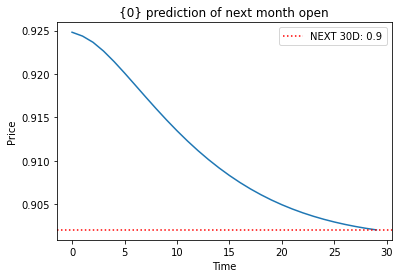

In [49]:
plt.plot(lst_output)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open")
plt.axhline(y=lst_output[len(lst_output)-1], color='red', linestyle=':', label='NEXT 30D: {0}'.format(round(float(*lst_output[len(lst_output)-1]),2)))
plt.legend();

## 6. Implemenation refactored

In [9]:
# R
mape_dict = {}

for ratio in df:
   # split into train/test
    if ratio == 'Date':
        continue
    else:
        one_ratio_df = pd.DataFrame(df[['Date', ratio]])
        train_data, validation_data, length_train, length_validation = split_train_val(one_ratio_df)
        # call train_split
        dataset_train_scaled = train_split(train_data)
        # create X_train, y_train
        X_train, X_val, y_train, y_val, time_step = create_x_y_train(dataset_train_scaled, length_train)
        # create X_test, y_test
        X_test, y_test = create_x_y_test(validation_data, length_validation, time_step)
        # run LSTM model
        mape, model = lstm_model(X_train, y_train, X_val, y_val, X_test, y_test)
        mape_dict[ratio] = round(mape, 3)

2022-09-15 18:15:32.013336: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 18:15:32.287993: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/400
4/4 [==============================] - 11s 174ms/step - loss: 57.3971 - mae: 0.2149 - mape: 57.3971 - val_loss: 2.1371 - val_mae: 0.0084 - val_mape: 2.1371
Epoch 2/400
4/4 [==============================] - 0s 18ms/step - loss: 7.2345 - mae: 0.0267 - mape: 7.2345 - val_loss: 4.5836 - val_mae: 0.0179 - val_mape: 4.5836
Epoch 3/400
4/4 [==============================] - 0s 18ms/step - loss: 6.6028 - mae: 0.0237 - mape: 6.6028 - val_loss: 1.6385 - val_mae: 0.0065 - val_mape: 1.6385
Epoch 4/400
4/4 [==============================] - 0s 19ms/step - loss: 6.1435 - mae: 0.0225 - mape: 6.1435 - val_loss: 4.7973 - val_mae: 0.0187 - val_mape: 4.7973
Epoch 5/400
4/4 [==============================] - 0s 18ms/step - loss: 5.9483 - mae: 0.0215 - mape: 5.9483 - val_loss: 4.9739 - val_mae: 0.0194 - val_mape: 4.9739
Epoch 6/400
4/4 [==============================] - 0s 18ms/step - loss: 6.5034 - mae: 0.0235 - mape: 6.5034 - val_loss: 5.0800 - val_mae: 0.0199 - val_mape: 5.0800
Epoch 7/400


In [ ]:
mape_dict

In [ ]:
print(f'The average MAPE of all {len(mape_dict)} ratios is: {round(sum(mape_dict.values()) / len(mape_dict), 2)}%')

## 8. Recommend best 5 ratios

In [ ]:
# sort from best to worst
bst_list = sorted(mape_dict.items(), key=lambda item: item[1])

In [ ]:
best_five = dict(bst_list)
best_five = {k: best_five[k] for k in list(best_five)[:5]}
for k in best_five:
    print(k)

## 9. Compute average true range (ATR)

In [ ]:
# once a model is selected based on the lowest mape, we can download open, high, low prices
# convert best 5 to list
best_list = list(best_five.keys())
# get the 5 best ratios from the original dataset
df.set_index('Date', inplace=True)
best_atr_df = df[[c for c in df.columns if c in best_list]]

In [ ]:
i = 0
length = best_atr_df.shape[1]
long_list = []
short_list = []

while i < length:
    ratio = best_atr_df.columns.str.split('_').tolist()[i]
    # get the long prices (numerator) for a defined period first
    numerator = ratio[0]
    long = yf.Ticker(numerator).history(period="1mo").reset_index()
    high_low_long = long['High'] - long['Low']
    high_close_long = np.abs(long['High'] - long['Close'].shift())
    low_close_long = np.abs(long['Low'] - long['Close'].shift())
    ranges_long = pd.concat([high_low_long, high_close_long, low_close_long], axis=1)
    true_range_long = np.max(ranges_long, axis=1)
    long[f'{numerator}'] = true_range_long.rolling(14).sum()/14
    long_list.append(long)
    
    # get the short prices (denominator) for a defined period second
    denominator = ratio[1]
    short = yf.Ticker(denominator).history(period="1mo").reset_index()
    high_low_short = short['High'] - short['Low']
    high_close_short = np.abs(short['High'] - short['Close'].shift())
    low_close_short = np.abs(short['Low'] - short['Close'].shift())
    ranges_short = pd.concat([high_low_short, high_close_short, low_close_short], axis=1)
    true_range_short = np.max(ranges_short, axis=1)
    short[f'{denominator}'] = true_range_short.rolling(14).sum()/14
    short_list.append(short)
    
    i += 1

In [ ]:
long_df = []
short_df = []

# get list of last columns of long and short ATRs
for long in long_list:
    long_df.append(pd.DataFrame(long[long.columns[-1]]))

for short in short_list:
    short_df.append(pd.DataFrame(short[short.columns[-1]]))  

In [ ]:
# generate list of best ratios as tuples
long_short = list(zip(long_df, short_df))

In [ ]:
# loop to combine
final_conc_df = pd.DataFrame()
for i in range(0, len(long_short)):
    conc_df = pd.concat([pd.DataFrame(long_short[i][0]), pd.DataFrame(long_short[i][1])], axis=1)
    final_conc_df = pd.concat([final_conc_df, conc_df], axis=1)

In [ ]:
# add back 'Date' columns
final_conc_df = pd.concat([final_conc_df, short_list[0]['Date']], axis=1)

In [ ]:
# drop NANs
final_conc_df.dropna(how='any', axis=0, inplace=True)
# set index to 'Date' column
final_conc_df.set_index('Date', inplace=True)

In [ ]:
# compute ATR for long/short ratios
final_atr_df = pd.DataFrame()
for i in range(0, final_conc_df.shape[1], 2):
    final_atr_df[f'{final_conc_df.columns[i]}_{final_conc_df.columns[i+1]}'] = \
                  final_conc_df.iloc[:, i] / final_conc_df.iloc[:, i+1]

In [ ]:
# collect all ATRs in a dict
atr_dict = {}
for col in final_atr_df:
    atr_dict[col] = round(final_atr_df[col].mean(), 3)

In [ ]:
atr_dict

## 10. Empirical information about the best ratios

In [ ]:
# get best 5 ratios 
best_ratios = list(atr_dict.keys())
lst_mth_df = df[best_ratios][-20:]
lst_three_mth_df = df[best_ratios][-60:]

In [ ]:
pl_one_dict = {}
pl_three_dict = {}
ptf_value = 10000

# calcualte change for 20 trading days
for col in lst_mth_df.columns:
    delta_one = lst_mth_df[col][19] / lst_mth_df[col][0]
    pl_one_dict[col] = round(ptf_value * delta_one, 2)
    
# calcualte change for 60 trading days
for col in lst_mth_df.columns:
    delta_three = lst_three_mth_df[col][59] / lst_three_mth_df[col][0]
    pl_three_dict[col] = round(ptf_value * delta_three, 2)

In [ ]:
pl_one_dict